## Problem 1 : 爬大盤指數 TAIEX
---
### 已有檔案所以將爬蟲程式註解

In [2]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import datetime
import calendar

import time

In [49]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

day = "20121201"
end_date = 20181201
start_date = datetime.datetime.fromisoformat("2012-12-01")

TAIEX_df = pd.DataFrame()
i = 0
while int(day) < end_date : 
    i+=1
    
    print('Get data in :', day)
    
    r = requests.post('https://www.twse.com.tw/indicesReport/MI_5MINS_HIST?response=csv&date='+ day )
    df = pd.read_csv(StringIO(r.text), header=["日期" in l for l in r.text.split("\r\n")].index(True)).drop(['Unnamed: 5'],axis=1)
    
    ## 不設休息可能被鎖IP
    time.sleep(3)
    
    r = requests.post('https://www.twse.com.tw/exchangeReport/FMTQIK?response=csv&date='+ day )
    df_volumns = pd.read_csv(StringIO(r.text), header=["日期" in l for l in r.text.split("\r\n")].index(True)).drop(['Unnamed: 6'],axis=1)   
    df['Volume'] = df_volumns.成交股數
    TAIEX_df = TAIEX_df.append(df)
    
    day = str (add_months(start_date, i)).replace("-", "")
    ## 不設休息可能被鎖IP
    time.sleep(3)

## 重設columns
columns = ['Date','Open','High','Low','Close','Volume']
TAIEX_df.columns = columns

## 將字串儲存成數字 (eg. '9,487.87')
for c in columns:
    if c != 'Date':
        TAIEX_df[c] = TAIEX_df[c].str.replace(',','').astype(float)

## 儲存乾淨的台指
TAIEX_df.to_csv('pure_TAIEX.csv', index=False)

TAIEX_df

## Problem 2 : Triple barrier
---
- 讀取爬好的檔案近來，計算20的閥值

In [26]:
TAIEX_df = pd.read_csv('pure_TAIEX.csv')

In [27]:
import numpy as np
import math
def triple_barrier(price, ub, lb, period):

    ## 取超出邊界的資料，記錄第一筆為邊界收益，沒超出的話取時間內最後一筆
    def record_price(s):
        return np.append(s[(s / s[0] > ub) | (s / s[0] < lb)], s[-1])[0]/s[0]
    ## 今天往後20天，所以+1
    p = price.rolling(period+1).apply(record_price, raw=True).shift(-period)

    signal = pd.Series(0, p.index)
    signal.loc[p > ub] = 1
    signal.loc[p < lb] = 2
    ret = pd.DataFrame({'triple_barrier_profit':p, 'triple_barrier_signal':signal})

    return ret

ret = triple_barrier(TAIEX_df.Close, 1.04, 0.98, 20)


In [28]:
TAIEX_df['triple_barrier_label'] = ret.triple_barrier_signal
TAIEX_df

,Date,Open,High,Low,Close,Volume,triple_barrier_label
0,101/12/03,7582.65,7628.29,7562.19,7599.91,3.696525e+09,0
1,101/12/04,7572.11,7600.98,7536.66,7600.98,3.947861e+09,0
2,101/12/05,7575.63,7650.12,7567.46,7649.05,4.858911e+09,0
3,101/12/06,7660.97,7673.62,7616.79,7623.26,4.399887e+09,0
4,101/12/07,7640.25,7672.92,7631.63,7642.26,3.888752e+09,0
...,...,...,...,...,...,...,...
1470,107/11/26,9679.98,9847.35,9679.98,9765.36,3.938988e+09,0
1471,107/11/27,9728.95,9781.40,9688.74,9778.62,4.333009e+09,0
1472,107/11/28,9774.03,9890.89,9767.14,9884.31,5.413429e+09,0
1473,107/11/29,9959.87,10001.85,9885.36,9885.36,5.863859e+09,0


## Problem 3 : 8 technical indicators
---
- 計算 MA 價格 : 以rolling配合`mean`輸出移動平均價

In [29]:
def MA(price, period):
    return price.rolling(period).apply(np.mean)

In [30]:
MA_days = [5,10,20,60]
for day in MA_days :
    label_name = 'MA_' + str(day)
    TAIEX_df[label_name] = MA(TAIEX_df.Close, day)

In [31]:
TAIEX_df

,Date,Open,High,Low,Close,Volume,triple_barrier_label,MA_5,MA_10,MA_20,MA_60
0,101/12/03,7582.65,7628.29,7562.19,7599.91,3.696525e+09,0,NaN,NaN,NaN,NaN
1,101/12/04,7572.11,7600.98,7536.66,7600.98,3.947861e+09,0,NaN,NaN,NaN,NaN
2,101/12/05,7575.63,7650.12,7567.46,7649.05,4.858911e+09,0,NaN,NaN,NaN,NaN
3,101/12/06,7660.97,7673.62,7616.79,7623.26,4.399887e+09,0,NaN,NaN,NaN,NaN
4,101/12/07,7640.25,7672.92,7631.63,7642.26,3.888752e+09,0,7623.092,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1470,107/11/26,9679.98,9847.35,9679.98,9765.36,3.938988e+09,0,9726.576,9765.284,9798.1025,10273.885500
1471,107/11/27,9728.95,9781.40,9688.74,9778.62,4.333009e+09,0,9733.502,9765.562,9810.7280,10252.463500
1472,107/11/28,9774.03,9890.89,9767.14,9884.31,5.413429e+09,0,9762.060,9774.805,9814.8370,10234.465000
1473,107/11/29,9959.87,10001.85,9885.36,9885.36,5.863859e+09,0,9796.190,9780.695,9816.8680,10215.531333


---
- 計算 RSI 指標 

In [32]:
def RSI(price, period):
    up_move = np.zeros(len(price))
    down_move = np.zeros(len(price))
    
    for x in range(1,len(price)):
        if price[x] > price[x-1]:
            up_move[x] = price[x] - price[x-1]

        if price[x] < price[x-1]:
            down_move[x] = abs(price[x] - price[x-1])  

    ## 計算移動上升與下降，並計算RS 跟 RSI
    average_up = np.zeros(len(price))
    average_down = np.zeros(len(price))
    
    average_up[period] = up_move[1:period+1].mean()
    average_down[period] = down_move[1:period+1].mean()
    
    RS = np.zeros(len(price))
    RSI = np.zeros(len(price))
    
    RS[14] = average_up[period] / average_down[period]
    RSI[14] = 100 - (100/(1+RS[period]))
    
    ## 更新移動上升與下降，並計算RS 跟 RSI
    for x in range(period+1, len(price)):
        #前一天*13份+今天
        average_up[x] = (average_up[x-1]*(period-1)+up_move[x])/period
        average_down[x] = (average_down[x-1]*(period-1)+down_move[x])/period
        RS[x] = average_up[x] / average_down[x]
        RSI[x] = 100 - (100/(1+RS[x]))
    return RS, RSI

In [33]:
RS_, RSI_ = RSI(TAIEX_df.Close,14)

TAIEX_df['RSI_14'] = RSI_
TAIEX_df

,Date,Open,High,Low,Close,Volume,triple_barrier_label,MA_5,MA_10,MA_20,MA_60,RSI_14
0,101/12/03,7582.65,7628.29,7562.19,7599.91,3.696525e+09,0,NaN,NaN,NaN,NaN,0.000000
1,101/12/04,7572.11,7600.98,7536.66,7600.98,3.947861e+09,0,NaN,NaN,NaN,NaN,0.000000
2,101/12/05,7575.63,7650.12,7567.46,7649.05,4.858911e+09,0,NaN,NaN,NaN,NaN,0.000000
3,101/12/06,7660.97,7673.62,7616.79,7623.26,4.399887e+09,0,NaN,NaN,NaN,NaN,0.000000
4,101/12/07,7640.25,7672.92,7631.63,7642.26,3.888752e+09,0,7623.092,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1470,107/11/26,9679.98,9847.35,9679.98,9765.36,3.938988e+09,0,9726.576,9765.284,9798.1025,10273.885500,43.356907
1471,107/11/27,9728.95,9781.40,9688.74,9778.62,4.333009e+09,0,9733.502,9765.562,9810.7280,10252.463500,44.269531
1472,107/11/28,9774.03,9890.89,9767.14,9884.31,5.413429e+09,0,9762.060,9774.805,9814.8370,10234.465000,51.040585
1473,107/11/29,9959.87,10001.85,9885.36,9885.36,5.863859e+09,0,9796.190,9780.695,9816.8680,10215.531333,51.104144


---
- 計算 MACD 指標 

In [34]:
def MACD(df) :
    # 取12、26天的指數權重平均
    k = df.Close.ewm(span=12, adjust=False, min_periods=12).mean()
    d = df.Close.ewm(span=26, adjust=False, min_periods=26).mean()

    macd = k - d
    macd_signal = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    macd_histogram = macd - macd_signal
    # Add all of our new values for the MACD to the dataframe
    df['MACD'] = macd
    df['MACD_signal'] = macd_signal
    df['MACD_histogram'] = macd_histogram

MACD(TAIEX_df)

In [35]:
TAIEX_df.to_csv('TAIEX_with_index.csv',index=False)

In [36]:
## 移除 NaN 並保留只到 2018-12-02前的資料
TAIEX_df = TAIEX_df.dropna().reset_index(drop=True)
TAIEX_df.to_csv('TAIEX_with_index.csv',index=False)

## Problem 4 : PCA
---
- 繪製 PCA 的累加圖
- 壓縮 開高收低量、MA、RSI、MACD 成2維PCA
- 根據PCA數據繪圖

In [17]:
# 移除 NaN，並保留對應columns
df_PCA = TAIEX_df.drop(['Date','triple_barrier_label'], axis=1)
Y_label = TAIEX_df.triple_barrier_label

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 取等維度的 PCA
pca = PCA(n_components=len(df_PCA.columns))
pca.fit(df_PCA.values)


PCA(n_components=13)

In [54]:
pca.explained_variance_ratio_


array([1.00000000e+00, 3.82098351e-12, 6.36411862e-14, 1.18340937e-14,
       2.69176669e-15, 1.26402558e-15, 5.42372335e-16, 4.01002217e-16,
       1.30590042e-16, 1.19249471e-16, 9.19267923e-18, 5.77844643e-18,
       6.69190532e-47])

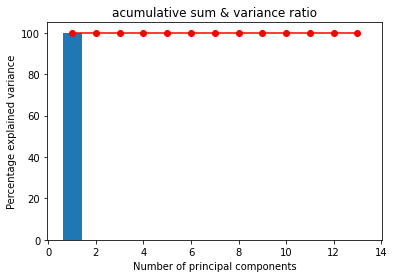

In [21]:
## 畫 PCA 的圖
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.title("acumulative sum & variance ratio")
plt.show(block=False)

In [24]:
X_reduced = PCA(n_components = 2).fit_transform(df_PCA.values)

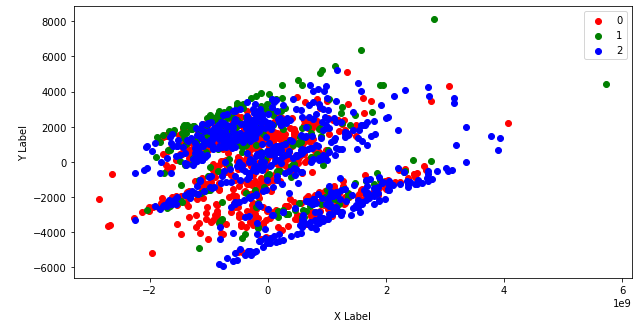

In [25]:
import matplotlib.pyplot as plt

# 設定label與對應的顏色
y_label_list = [0,1,2]
colors = ['r', 'g','b']

fig,ax=plt.subplots(figsize=(10,5))

#根據label來畫圖
for y , color in zip(y_label_list, colors):
    xs = X_reduced[Y_label == y].T[0]
    ys = X_reduced[Y_label == y].T[1]
    ax.scatter(xs, ys, c = color,  marker='o', label=y)
ax.legend()
ax.set_xlabel('\nX Label')
ax.set_ylabel('\nY Label')
plt.show()

In [ ]:
###### Discussion
print(pca.components_[0])

df_PCA

In [46]:
from sklearn import preprocessing

x = df_PCA.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
normalized_df = min_max_scaler.fit_transform(x)


In [49]:
pca = PCA(n_components=len(df_PCA.columns))
pca.fit(normalized_df)

PCA(n_components=13)

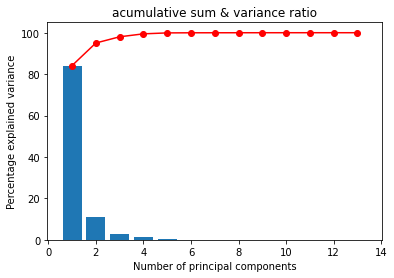

In [50]:
## 畫 PCA 的圖
scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Percentage explained variance")
plt.title("acumulative sum & variance ratio")
plt.show(block=False)

In [51]:
print(pca.components_[0])

[ 0.32775184  0.34862459  0.31233337  0.32523594  0.10294972  0.35668591
  0.36763348  0.38469374  0.38059584  0.01851378  0.02435158  0.03015276
 -0.00661902]
